In [1]:
import sys
import pandas as pd
import datetime
import os.path
from os import path
import requests
import numpy as np
import time
import pytz
# from sklearn.impute import KNNImputer
import json
from sklearn.metrics import mean_absolute_error
import calendar
import os
from dateutil.relativedelta import relativedelta
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
% matplotlib inline
address = "https://m3.meazon.com/"

In [126]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def gof(x,y):
    lgof = np.sum((y-x)**2/x)
    if lgof> chi[step-2]:
        lgof=1
    else:
        lgof= 0
    return lgof

chi = [6.63,9.21,11.3,13.3,15.1,16.8,18.5,20.1,21.7,23.2,24.7,26.2,27.7,29.1,30.6,32,33.4,34.8,36.2,37.6,38.9,40.3,41.6,43,44.3,45.6,47,48.3,49.6]

In [101]:
# read data from csv
df = pd.read_csv('fridge.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
df = df.sort_values(by="Timestamp")

# df['Timestamp'] = df['Timestamp'].astype('datetime64[s]')
df = df.set_index('Timestamp', drop=True)
for col in df.columns:
    df[col] = df[col].astype('float64')
    
# df includes active and apparent power columns, along with timestamps
df['totalpwr'] = np.sqrt((df['pwr_L1'])**2+(df['rpwr_L1'])**2)
df['active'] = df['pwr_L1']
df =df[['totalpwr','active']]
df['totalpwr'] = sp.signal.medfilt(df['totalpwr'])
df.head()

,totalpwr,active
Timestamp,,
2020-04-02 11:12:13.281,23.817374,14.166867
2020-04-02 11:12:13.301,24.029763,14.166867
2020-04-02 11:12:13.321,24.326642,14.150355
2020-04-02 11:12:13.341,24.326642,14.183378
2020-04-02 11:12:13.361,24.326642,14.216401


In [127]:
# # plot raw data
# i=0
# fig, ax1 = plt.subplots(figsize=(14, 7.0))
# plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# color = 'tab:purple'
# ax1.set_xlabel('Time')
# ax1.set_ylabel('Apparent power [VA]', color=color)
# ax1.plot(df.index, df['totalpwr'], color=color)
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['total power'], loc=2)


C:\Users\Emily\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


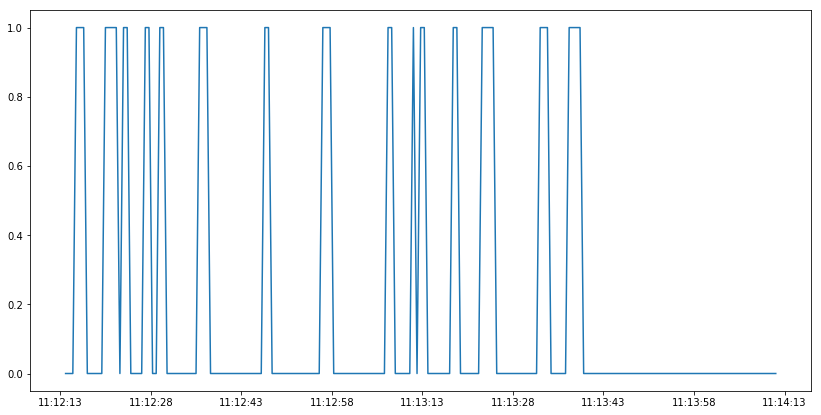

In [6]:
# Define window size as step, apply gof function over rows to detect events

step = 30
supervised = series_to_supervised(df, step, step)
supervised = supervised.iloc[1::step, :]
supervised['lgof']=0

for i in range(0,supervised.shape[0]):
    supervised['lgof'].iloc[i] = gof(supervised[supervised.columns[:step]].iloc[i].values,supervised[supervised.columns[step:-1]].iloc[i].values)

# supervised['lgof'] = supervised.apply(lambda row : gof(row[['var1(t-3)','var1(t-2)','var1(t-1)']].values,row[['var1(t)','var1(t+1)','var1(t+2)']].values 
#                                   ), axis = 1) 
fig = plt.figure(figsize=(14, 7.0))
plt.plot(supervised.index,supervised.lgof)

In [102]:
# Average df's rows every [step] rows and concatenate active and apparent power to supervised

dfn = df.iloc[step+1:].copy()
dfn['ts'] = dfn.index
dfn.reset_index(inplace=True,drop=True)
dfn = dfn.groupby(np.arange(len(dfn))//step).mean()
dfn = dfn.iloc[:-1]
supervised['totalpwr'] = dfn['totalpwr'].values
supervised['active'] = dfn['active'].values


In [103]:
dfn = supervised.copy()
dfn = dfn[['totalpwr','active','lgof']]
dfn.head()

,totalpwr,active,lgof
Timestamp,,,
2020-04-02 11:12:13.901,24.255988,14.174572,0
2020-04-02 11:12:14.501,24.190544,14.160813,0
2020-04-02 11:12:15.101,24.093535,14.352896,0
2020-04-02 11:12:15.701,33.034213,27.824629,1
2020-04-02 11:12:16.301,25.379396,23.468345,1


In [125]:
# supper = np.ma.masked_where(dfn['lgof']==1, dfn['totalpwr'])
# slower = np.ma.masked_where(dfn['lgof'] ==0, dfn['totalpwr'])
# fig, ax = plt.subplots(figsize=(14, 7.0))
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
# ax.plot(dfn.index, supper,'-',dfn.index,slower,'-*')
# ax.legend(['No event','Event'])

Text(0.5,1,'Event detection')

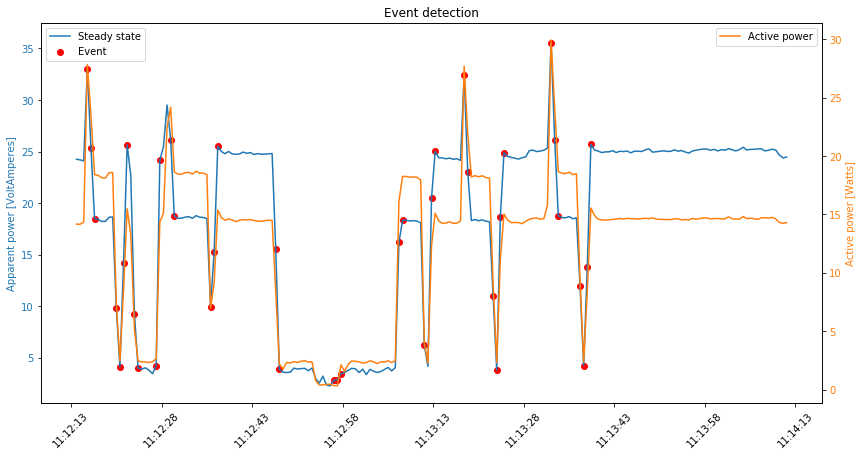

In [124]:

import matplotlib.colors as colors

fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'
ax1.plot(dfn.index, dfn['totalpwr'], '-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Apparent power [VoltAmperes]', color=color)
# Add below threshold markers
below_threshold = dfn['lgof']>0
ax1.scatter(dfn.index[below_threshold], dfn['totalpwr'][below_threshold], color='red') 
ax1.legend(['Steady state','Event'],loc=2)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'


ax2.set_ylabel('Active power [Watts]', color=color)  # we already handled the x-label with ax1
ax2.plot(dfn.index, dfn['active'], '-',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Active power'], loc=1)
plt.title('Event detection')

In [ ]:
#############################################################################################

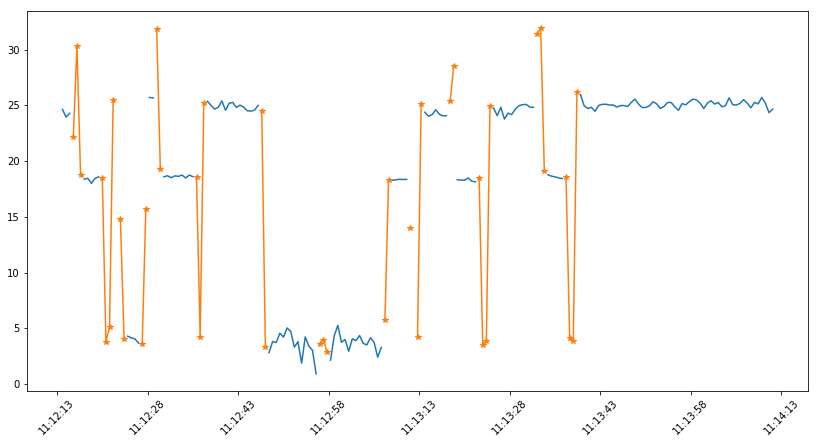

In [169]:
supper = np.ma.masked_where(df['lgof']==1, df['totalpwr'])
slower = np.ma.masked_where(df['lgof'] ==0, df['totalpwr'])
fig, ax = plt.subplots(figsize=(14, 7.0))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.plot(df.index, supper,'-',df.index,slower,'-*')

In [29]:
df = pd.concat([df,supervised['lgof']],axis = 1)
df = df.iloc[3:]
# df.dropna(inplace = True)
df.head()

,totalpwr,lgof
Timestamp,,
2020-04-02 11:12:13.341,24.326642,NaN
2020-04-02 11:12:13.361,24.326642,0.0
2020-04-02 11:12:13.381,24.386135,NaN
2020-04-02 11:12:13.401,24.393076,NaN
2020-04-02 11:12:13.421,24.393076,0.0


In [30]:
for i in range(1,df.shape[0],3):
    if df['lgof'].iloc[i]>0:
        df['lgof'].iloc[i:i+3]=0
        
        difn = df['totalpwr'].iloc[i-1] - df['totalpwr'].iloc[i]
        dif1 = df['totalpwr'].iloc[i] - df['totalpwr'].iloc[i+1]
        dif2 = df['totalpwr'].iloc[i+1] - df['totalpwr'].iloc[i+2]
        
        if np.abs(np.abs(dif1-dif2)>10):

            maxind = np.argmax([np.abs(difn),np.abs(dif1),np.abs(dif2)])
            mx = [difn,dif1,dif2][maxind]
            
            if maxind>0:
                df['lgof'].iloc[i+maxind]=1
#                 if mx<0:
#                     df['lgof'].iloc[i+maxind+1]=1
#                 else:
#                     df['lgof'].iloc[i+maxind]=1
            else:
                df['lgof'].iloc[i]=1
        else:
            df['lgof'].iloc[i]=1
    else:
        df['lgof'].iloc[i:i+3]=0
        

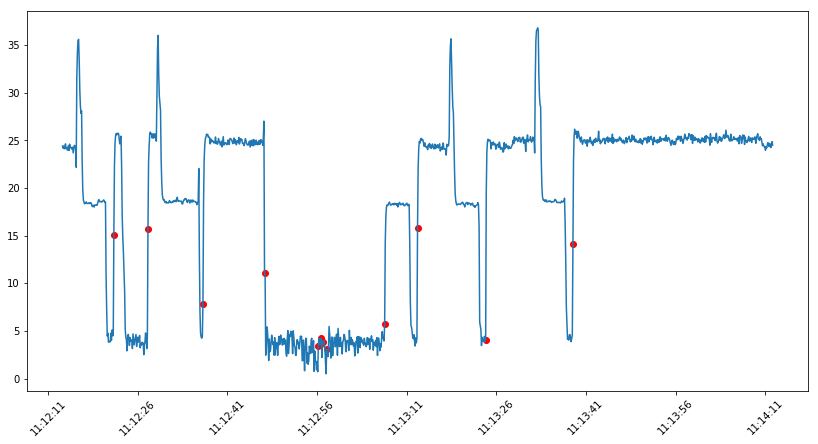

In [65]:

import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(14, 7.0))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.plot(df.index, df['totalpwr'], '-')
# Add below threshold markers
below_threshold = df['lgof']>0
plt.scatter(df.index[below_threshold], df['totalpwr'][below_threshold], color='red') 

